## 1- loading the datasets

The first data-set is the titanic data set, which could be fould in https://www.kaggle.com/competitions/titanic/data.

In [2]:
!kaggle competitions download -c titanic

100%|███████████████████████████████████████| 34.1k/34.1k [00:00<00:00, 328kB/s]
100%|███████████████████████████████████████| 34.1k/34.1k [00:00<00:00, 326kB/s]


In [9]:
!unzip titanic.zip -d './data/titanic/'

Archive:  titanic.zip
  inflating: ./data/titanic/gender_submission.csv  
  inflating: ./data/titanic/test.csv  
  inflating: ./data/titanic/train.csv  


In [2]:
#importing basic librarys
import pandas as pd
from sklearn import datasets
import numpy as np

We downloaded the data, let's load in a dataframe format.

In [3]:
#loading titanic in a dataframe
titanic_df = pd.read_csv('./data/titanic/train.csv', index_col=0)

Now we can examinate the first rows to see what the data looks like.

## 1.1 - Basic Exploratory analysis and transformations

Now we gonna explore some basic informations about the dataset. First, we gonna observe the first rows.

In [4]:
#show the first rows
titanic_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


To prepare the models we need informations about the type of the data on each column and we also have to look if it has missing values.

In [5]:
#basic informations
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Cabin has to much missing values and names won't give to us any information about predicting the Survived column. We gonna drop those columns. Moreover, the Age and Embarked has null entries to, but this two features is important so we gonna just replace the null entries. 

Before tackle the missing values the Fare also has a problem that i identify on other project working on the data set. The Fare is not a individual value for each entrie, the fare is a sum of all the Tickets that has the same value. This creates a Fare that is larger then the price of individual ticket and distort the meaning of the column. To correct this we will dived the fare by the count of tickets with same ticket number, therefore creating a fare representing the individual value of the ticket for each passager entrie.

In [6]:
#dropping name and cabin features
titanic_df = titanic_df.drop(columns=['Name','Cabin'],axis=1)

The following represents the problem with the fare described earlier.

In [7]:
titanic_df.iloc[titanic_df['Fare'].nlargest(20).index-1]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,
259,1,1,female,35.0,0,0,PC 17755,512.3292,C
680,1,1,male,36.0,0,1,PC 17755,512.3292,C
738,1,1,male,35.0,0,0,PC 17755,512.3292,C
28,0,1,male,19.0,3,2,19950,263.0000,S
89,1,1,female,23.0,3,2,19950,263.0000,S
342,1,1,female,24.0,3,2,19950,263.0000,S
439,0,1,male,64.0,1,4,19950,263.0000,S
312,1,1,female,18.0,2,2,PC 17608,262.3750,C
743,1,1,female,21.0,2,2,PC 17608,262.3750,C


From the sample above we can see that the fare does not correspond to a single passanger but to the sum of fares of all passangers with the same Ticket. To adjust this, we will take the tickets and divide the fare. 

In [8]:
#get the counter for each ticket.
tickets_count = titanic_df.groupby('Ticket')['Ticket'].count()
#split those bigger than 1
tickets_count = tickets_count[tickets_count > 1]

In [9]:
#for each ticket counter(greater then 1), dive the fare and update the column.
for ticket, counter in tickets_count.items():
    titanic_df.loc[titanic_df['Ticket'] == ticket, 'Fare'] = titanic_df.loc[titanic_df['Ticket'] == ticket, 'Fare']/counter


In [10]:
#checking the result
titanic_df.iloc[titanic_df['Fare'].nlargest(20).index-1]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,
528,0,1,male,NaN,0,0,PC 17483,221.77920,S
378,0,1,male,27.0,0,2,113503,211.50000,C
259,1,1,female,35.0,0,0,PC 17755,170.77640,C
680,1,1,male,36.0,0,1,PC 17755,170.77640,C
738,1,1,male,35.0,0,0,PC 17755,170.77640,C
312,1,1,female,18.0,2,2,PC 17608,131.18750,C
743,1,1,female,21.0,2,2,PC 17608,131.18750,C
119,0,1,male,24.0,0,1,PC 17558,123.76040,C
300,1,1,female,50.0,0,1,PC 17558,123.76040,C


We can seed that the values for the fare drops considerably and is more significative in contrast to the sum presented before.

To apply the model, we have to transform the categorical values.

In [11]:
from sklearn.preprocessing import OneHotEncoder

The column Sex we be transformed using one hot encoder technique. The one hot encoder will create a new binary column for each category present on the column.

In [12]:
#one hot encoder
one_hot_enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
#fitting
one_hot_enc = one_hot_enc.fit(titanic_df[['Sex']])

In [13]:
#create the new columns
titanic_df[one_hot_enc.get_feature_names_out()] = one_hot_enc.transform(titanic_df[['Sex']])

We substitute the Sex column by the categories created by the one hot encoder.

In [14]:
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_female,Sex_male
PassengerId,,,,,,,,,,,
1,0,3,male,22.0,1,0,A/5 21171,7.2500,S,0.0,1.0
2,1,1,female,38.0,1,0,PC 17599,71.2833,C,1.0,0.0
3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,1.0,0.0
4,1,1,female,35.0,1,0,113803,26.5500,S,1.0,0.0
5,0,3,male,35.0,0,0,373450,8.0500,S,0.0,1.0


Now we can drop the Sex column. From now on we can also drop the ticket information that will no longer be necessary

In [15]:
#drop the sex and ticket columns
titanic_df = titanic_df.drop(columns=['Sex', 'Ticket'],axis=1)

In [16]:
#checking 
titanic_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_female,Sex_male
PassengerId,,,,,,,,,
1,0,3,22.0,1,0,7.2500,S,0.0,1.0
2,1,1,38.0,1,0,71.2833,C,1.0,0.0
3,1,3,26.0,0,0,7.9250,S,1.0,0.0
4,1,1,35.0,1,0,26.5500,S,1.0,0.0
5,0,3,35.0,0,0,8.0500,S,0.0,1.0


The next step is preprocess the missing values. For the Embarked column we will use the knnimputer. Knnimputer uses the k-nearest neihbours procedure to estimate the missing values, its a simple and efective procedure. Before we can apply the imputer we have to transform the column in a numeric format for the algorithm, so let's proceed.

In [17]:
#all unique removing the nan value.
unique_embarked = titanic_df['Embarked'].unique()[:-1]
#get nan to compare
nan = titanic_df['Embarked'].unique()[-1] 
#creates a dictionary where each embarked value has a number
dict_embarked = {embarked:idx for idx, embarked in enumerate(unique_embarked)}
#applying the transformation based on the dictionary
titanic_df['Embarked'] = titanic_df['Embarked'].apply(lambda x: dict_embarked[x] if x is not nan else np.NaN)

Now we apply the Knnimputer on the dataset to estimate the missing values for Age and Embarked

In [18]:
from sklearn.impute import KNNImputer

In [19]:
#create a knnimputer
imputer = KNNImputer(n_neighbors=5)
#fitting
imputer = imputer.fit(titanic_df)
titanic_df[titanic_df.columns] = imputer.transform(titanic_df)

In [20]:
#rounding same values
titanic_df.loc[titanic_df['Embarked'] == 0.6, 'Embarked'] = 1

Now we can apply one hot enconding to this columns like we did in the Age column.

In [21]:
#create encoder
one_hot_enc_embarked = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
#fitting
one_hot_enc_embarked = one_hot_enc.fit(titanic_df[['Embarked']])

In [22]:
#create the new columns
titanic_df[one_hot_enc.get_feature_names_out()] = one_hot_enc.transform(titanic_df[['Embarked']])

In [23]:
#dropping the old column for Embarked
titanic_df = titanic_df.drop(columns=['Embarked'],axis=1)

In [24]:
titanic_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_0.0,Embarked_1.0,Embarked_2.0
PassengerId,,,,,,,,,,,
1,0.0,3.0,22.0,1.0,0.0,7.2500,0.0,1.0,1.0,0.0,0.0
2,1.0,1.0,38.0,1.0,0.0,71.2833,1.0,0.0,0.0,1.0,0.0
3,1.0,3.0,26.0,0.0,0.0,7.9250,1.0,0.0,1.0,0.0,0.0
4,1.0,1.0,35.0,1.0,0.0,26.5500,1.0,0.0,1.0,0.0,0.0
5,0.0,3.0,35.0,0.0,0.0,8.0500,0.0,1.0,1.0,0.0,0.0


Let's check.

In [25]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    float64
 1   Pclass        891 non-null    float64
 2   Age           891 non-null    float64
 3   SibSp         891 non-null    float64
 4   Parch         891 non-null    float64
 5   Fare          891 non-null    float64
 6   Sex_female    891 non-null    float64
 7   Sex_male      891 non-null    float64
 8   Embarked_0.0  891 non-null    float64
 9   Embarked_1.0  891 non-null    float64
 10  Embarked_2.0  891 non-null    float64
dtypes: float64(11)
memory usage: 115.8 KB


Columns is almost ready to the model, we just need to scale the numeric features to the same range.

Now we can scale the age and Fare features to a interval between 0 and 1.

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler = scaler.fit(titanic_df[['Age', 'Fare']])
titanic_df[['Age', 'Fare']] = scaler.transform(titanic_df[['Age', 'Fare']]) 

array([[<Axes: title={'center': 'Pclass'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>,
        <Axes: title={'center': 'Fare'}>],
       [<Axes: title={'center': 'Sex_female'}>,
        <Axes: title={'center': 'Sex_male'}>,
        <Axes: title={'center': 'Embarked_0.0'}>,
        <Axes: title={'center': 'Embarked_1.0'}>,
        <Axes: title={'center': 'Embarked_2.0'}>]], dtype=object)

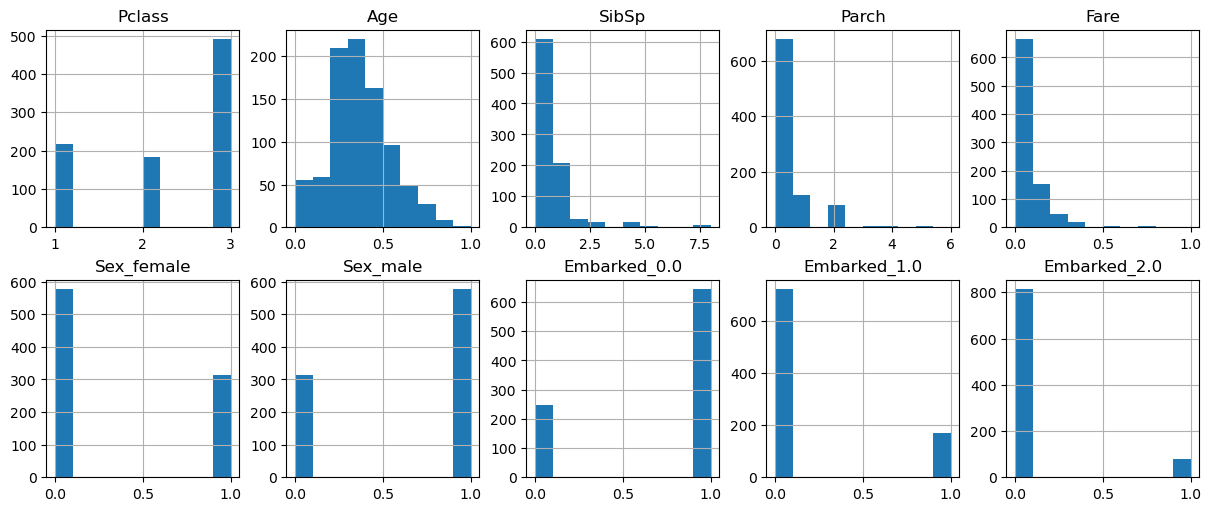

In [27]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 5, figsize=(12, 5), layout='constrained')
titanic_df[titanic_df.columns[1:]].hist(ax=axs)

<Axes: >

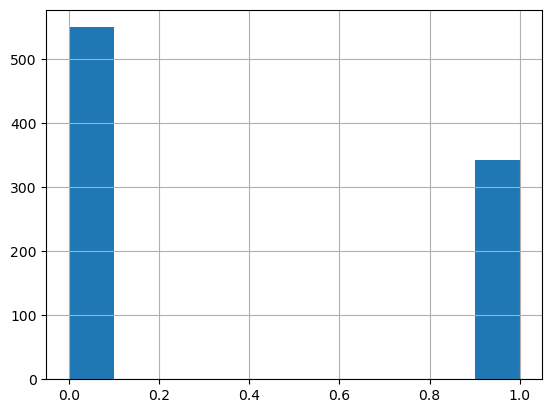

In [28]:
titanic_df['Survived'].hist()

The titanic dataset is a little off balance. 

We are trying to see the efects of normalization on the performance of the model. For the baseline, the age and fare will just scaled to 0 and 1 to perform the baseline. Then we will normalize the age and fare and extract the metrics to.

## 1.2 Base line for the titanic dataset

Now we gonna build the baseline. To test the normalization effect on a range of models, we gonna use the library for auto-ml pycaret. Pycaret wraps a wide range of classification models and will simplify the investigation to see what models can benefits from a normalization of the data.

To use pycaret we need to setup a classification experiment. 

In [29]:
# import ClassificationExperiment and init the class
from pycaret.classification import ClassificationExperiment
exp = ClassificationExperiment()

In [30]:
# init setup on exp
exp.setup(titanic_df, target = 'Survived', preprocess = False)

,Description,Value
0,Session id,741
1,Target,Survived
2,Target type,Binary
3,Original data shape,"(891, 11)"
4,Transformed data shape,"(891, 11)"
5,Transformed train set shape,"(623, 11)"
6,Transformed test set shape,"(268, 11)"
7,Numeric features,10


Now we just have to call the function compare_models and the library will apply a several models and validate with crossvalidation with k=10.

In [31]:
# compare baseline models
best = exp.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8508,0.8889,0.7866,0.8264,0.8010,0.6821,0.6883,80.6430
catboost,CatBoost Classifier,0.8411,0.8884,0.7196,0.8506,0.7754,0.6540,0.6634,0.9040
xgboost,Extreme Gradient Boosting,0.8379,0.8920,0.7781,0.8029,0.7860,0.6559,0.6609,0.0160
rf,Random Forest Classifier,0.8330,0.8816,0.7696,0.7998,0.7793,0.6454,0.6513,0.0400
gbc,Gradient Boosting Classifier,0.8299,0.8771,0.7154,0.8229,0.7620,0.6311,0.6379,0.0160
et,Extra Trees Classifier,0.8203,0.8672,0.7694,0.7726,0.7666,0.6207,0.6254,0.0320
ada,Ada Boost Classifier,0.8139,0.8506,0.7370,0.7744,0.7518,0.6035,0.6073,0.0150
knn,K Neighbors Classifier,0.8028,0.8514,0.7072,0.7632,0.7301,0.5757,0.5803,0.1600
lr,Logistic Regression,0.8011,0.8550,0.7116,0.7629,0.7327,0.5750,0.5793,0.2880
lda,Linear Discriminant Analysis,0.7995,0.8573,0.7072,0.7589,0.7291,0.5706,0.5743,0.0040


The results present on the table is a agreggation of all cross-validation steps. Remember that this dataset is imbalanced, so accuracy is not a good estimation. The f1 gives a much better estimative of the error. This time the lightgbm performs well on the most of metrics. 

Putting on a data frame.

In [32]:
results_titanic = exp.pull()

In [33]:
results_titanic

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8508,0.8889,0.7866,0.8264,0.8010,0.6821,0.6883,80.643
catboost,CatBoost Classifier,0.8411,0.8884,0.7196,0.8506,0.7754,0.6540,0.6634,0.904
xgboost,Extreme Gradient Boosting,0.8379,0.8920,0.7781,0.8029,0.7860,0.6559,0.6609,0.016
rf,Random Forest Classifier,0.8330,0.8816,0.7696,0.7998,0.7793,0.6454,0.6513,0.040
gbc,Gradient Boosting Classifier,0.8299,0.8771,0.7154,0.8229,0.7620,0.6311,0.6379,0.016
et,Extra Trees Classifier,0.8203,0.8672,0.7694,0.7726,0.7666,0.6207,0.6254,0.032
ada,Ada Boost Classifier,0.8139,0.8506,0.7370,0.7744,0.7518,0.6035,0.6073,0.015
knn,K Neighbors Classifier,0.8028,0.8514,0.7072,0.7632,0.7301,0.5757,0.5803,0.160
lr,Logistic Regression,0.8011,0.8550,0.7116,0.7629,0.7327,0.5750,0.5793,0.288
lda,Linear Discriminant Analysis,0.7995,0.8573,0.7072,0.7589,0.7291,0.5706,0.5743,0.004


## 1.3 Normalizing Age and Fare and build the models.

Now we gonna proceed with the normalization and build the models to compare.

First let's look at the distribution before the normalization.

array([<Axes: title={'center': 'Age'}>, <Axes: title={'center': 'Fare'}>],
      dtype=object)

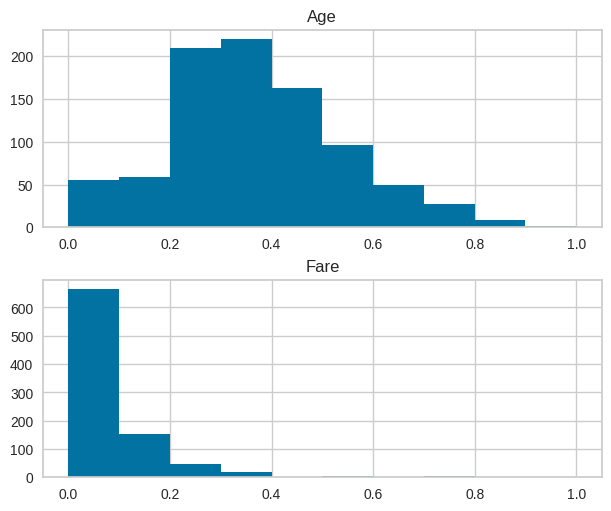

In [34]:
#plotting the distributions
fig, axs = plt.subplots(2, figsize=(6, 5), layout='constrained')
titanic_df[['Age', 'Fare']].hist(ax=axs)

To normalize we will use the quantileTransform with a normal distribution, this will force the distribution to as close to normal as possible.

In [35]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
pt = QuantileTransformer(output_distribution='normal')

In [36]:
pt = pt.fit(titanic_df[['Age', 'Fare']])
titanic_df[['Age-PT', 'Fare-PT']] = pt.transform(titanic_df[['Age', 'Fare']])

array([[<Axes: title={'center': 'Age-PT'}>,
        <Axes: title={'center': 'Fare-PT'}>]], dtype=object)

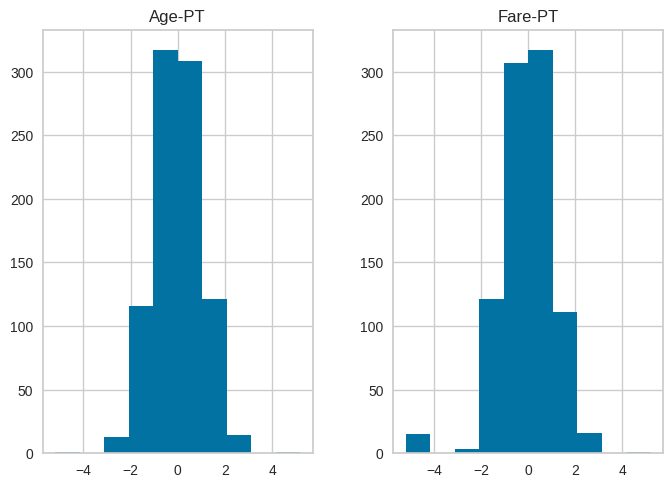

In [37]:
titanic_df[['Age-PT', 'Fare-PT']].hist()

It's not a perfect normal, but graphicaly its much more close to the normal that before the transformation.

In [38]:
titanic_copy = titanic_df.copy()

In [39]:
titanic_copy = titanic_copy.drop(columns=['Age', 'Fare'],axis=1)

Now we will build the experiment as before and look at the results.

In [40]:
#using the pycaret to test the models.
exp = ClassificationExperiment()
# init setup on exp
exp.setup(titanic_copy, target = 'Survived', preprocess = False)
# compare baseline models
best = exp.compare_models()

,Description,Value
0,Session id,561
1,Target,Survived
2,Target type,Binary
3,Original data shape,"(891, 11)"
4,Transformed data shape,"(891, 11)"
5,Transformed train set shape,"(623, 11)"
6,Transformed test set shape,"(268, 11)"
7,Numeric features,10


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8189,0.8609,0.6779,0.8223,0.7396,0.6033,0.6128,0.0150
knn,K Neighbors Classifier,0.8187,0.8567,0.7197,0.7968,0.7519,0.6101,0.6161,0.0070
catboost,CatBoost Classifier,0.8187,0.8691,0.6732,0.8241,0.7347,0.6006,0.6123,0.8980
rf,Random Forest Classifier,0.8124,0.8736,0.6944,0.7960,0.7380,0.5935,0.6000,0.0390
lightgbm,Light Gradient Boosting Machine,0.8124,0.8752,0.7236,0.7772,0.7451,0.5973,0.6027,76.6450
lr,Logistic Regression,0.8123,0.8534,0.7156,0.7830,0.7444,0.5970,0.6013,0.0050
xgboost,Extreme Gradient Boosting,0.8076,0.8646,0.7239,0.7659,0.7404,0.5883,0.5926,0.0100
ada,Ada Boost Classifier,0.8043,0.8478,0.6987,0.7743,0.7311,0.5783,0.5832,0.0150
et,Extra Trees Classifier,0.8027,0.8540,0.7071,0.7695,0.7317,0.5769,0.5828,0.0320
ridge,Ridge Classifier,0.8011,0.0000,0.7031,0.7635,0.7287,0.5727,0.5765,0.0040


Extracting the results into a frame to compare:

In [41]:
results_titanic_norm = exp.pull()

In [42]:
results_titanic_norm 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8189,0.8609,0.6779,0.8223,0.7396,0.6033,0.6128,0.015
knn,K Neighbors Classifier,0.8187,0.8567,0.7197,0.7968,0.7519,0.6101,0.6161,0.007
catboost,CatBoost Classifier,0.8187,0.8691,0.6732,0.8241,0.7347,0.6006,0.6123,0.898
rf,Random Forest Classifier,0.8124,0.8736,0.6944,0.7960,0.7380,0.5935,0.6000,0.039
lightgbm,Light Gradient Boosting Machine,0.8124,0.8752,0.7236,0.7772,0.7451,0.5973,0.6027,76.645
lr,Logistic Regression,0.8123,0.8534,0.7156,0.7830,0.7444,0.5970,0.6013,0.005
xgboost,Extreme Gradient Boosting,0.8076,0.8646,0.7239,0.7659,0.7404,0.5883,0.5926,0.010
ada,Ada Boost Classifier,0.8043,0.8478,0.6987,0.7743,0.7311,0.5783,0.5832,0.015
et,Extra Trees Classifier,0.8027,0.8540,0.7071,0.7695,0.7317,0.5769,0.5828,0.032
ridge,Ridge Classifier,0.8011,0.0000,0.7031,0.7635,0.7287,0.5727,0.5765,0.004


## 1.4 - Comparing the results

Next, we will look which models performs better and which not perfomed better.

In [47]:
results_list = []
results_index = []
#takes the diference between the results
for index in results_titanic_norm.index:
    results_norm = results_titanic_norm.loc[index][1:]
    results_base = results_titanic.loc[index][1:]
    results_index.append(index)
    results_list.append([results_norm - results_base])

Creating a dictionary of for the results and transform to a dataframe.

In [49]:
dict_results = {index:[] for index in results_list[0][0].index}
#putting the results on a dictionary
for key in dict_results.keys():
    for results in results_list:
        dict_results[key].append(results[0][key])

#transform on a dataframe
results_titanic_df = pd.DataFrame(dict_results)
#setting the index
results_titanic_df['index'] = pd.DataFrame(results_index)
results_titanic_df = results_titanic_df.set_index('index')

In [50]:
results_titanic_df

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
index,,,,,,,,
gbc,0.0063,0.0025,0.0212,0.0017,0.0122,0.0158,0.0154,0.001
xgboost,-0.0099,0.0058,-0.0040,-0.0120,-0.0109,-0.0193,-0.0166,0.000
catboost,-0.0257,0.0035,-0.0418,-0.0294,-0.0398,-0.0576,-0.0548,0.069
rf,-0.0081,-0.0028,-0.0415,0.0128,-0.0180,-0.0213,-0.0182,-0.002
lr,0.0064,0.0035,0.0047,0.0090,0.0074,0.0131,0.0124,-0.005
ada,-0.0192,-0.0173,-0.0625,-0.0068,-0.0338,-0.0460,-0.0470,-0.001
lightgbm,-0.0387,0.0028,-0.0542,-0.0489,-0.0520,-0.0827,-0.0823,1.483
lda,0.0032,0.0033,-0.0037,0.0027,0.0012,0.0050,0.0031,0.000
ridge,0.0048,0.0000,-0.0078,0.0071,0.0009,0.0070,0.0054,0.000


Roughly looks like the normalized version is worst on the majority of models but not by much, is only a slight better on some models.

The logistic regression, linear discriminant analyses and naive bayes, assumes a normal distribuiton about the data and as we may expect they perform better with the normalization setup, but the diference is not so significative, one can even argue that is equal taking in consideration the efficiency of the crossvalidation and some metrics perform worst on some metric cases. Now we analyze why this is happening. Let's see graphically what happens when we normalize vs just scaled data.

We saved a version of the titanic_df before dropping the normalized features. Lets verify the features.

In [51]:
import seaborn as sns

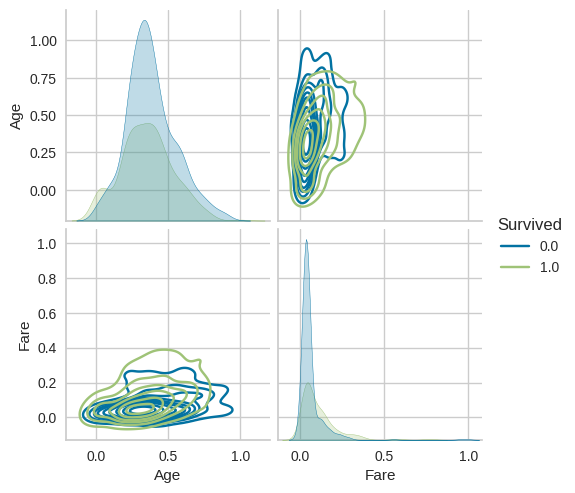

In [52]:
sns.pairplot(titanic_df[['Age', 'Fare', 'Survived']], hue="Survived", kind='kde')

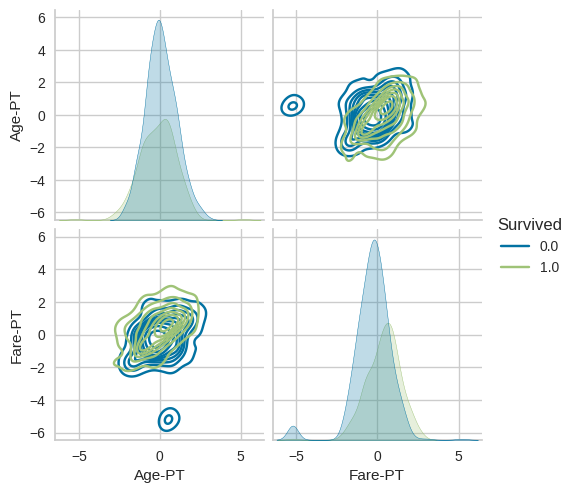

In [53]:
sns.pairplot(titanic_df[['Age-PT', 'Fare-PT', 'Survived']], hue="Survived", kind ='kde')

Comparing the two plots, we can see that a little blob which reseambles a egg has formed when we normalized the data. We can observe that the distribution of the survived and not survived is a little more off one another. However this is not suffificent for the model gain performance and the distribution is almost overlapping one another which makes the separability dificult for the models taking on consideration this two features.

Now we are going to analyze other datasets. 

## 2-The wine dataset

The next dataset is the wine data set and we are going to try to rpedict the class of the wine taking on to account some caracteristics of the wine. The titanic dataset has only two numeric atributes, wich makes difficult to some classifiers to perform welll like the logistic regression. With more numeric features we may expect normalization to be more significative.

The dataset is on the scikit-learn library, lets load the data.

In [43]:
#load the wine dataset as a dataframe
wine_df = datasets.load_wine(as_frame=True)['frame']

## 2.1- Basic Exploratory Analysis and Transformations

The wine dataset is another classic data-set for machine learning. This data-set is more easy to work with that the first one and doesn't have any categorical variable as we can see with the head() function.

In [44]:
#looking at the five first entries.
wine_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


We gonna use this dataset to predict the class of the wine, honestly I don't know much of wine but for this article we only need to know that the target column assumes either 3 options, {0,1,2}. So the objective is to predict wich of the 3 class the wine is, based on the rest of the features which is caracteristics of the wine. 

To build the baseline we will just put all the features on the same range like we did on the titanic data-set.

In [45]:
#selecting the feature columns
feature_columns = wine_df.columns[:-1]
#scaling the features
scaler_wine = MinMaxScaler()
scaler_wine = scaler_wine.fit(wine_df[feature_columns])
#updating the features.
wine_df[feature_columns] = scaler_wine.transform(wine_df[feature_columns]) 

In [46]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

This dataset doesn't have any missing values and all the features are numeric and doesn't require much transformations we just need to put all features on the same scale.

Let's take a look on the distributions.

array([[<Axes: title={'center': 'alcohol'}>,
        <Axes: title={'center': 'malic_acid'}>,
        <Axes: title={'center': 'ash'}>,
        <Axes: title={'center': 'alcalinity_of_ash'}>],
       [<Axes: title={'center': 'magnesium'}>,
        <Axes: title={'center': 'total_phenols'}>,
        <Axes: title={'center': 'flavanoids'}>,
        <Axes: title={'center': 'nonflavanoid_phenols'}>],
       [<Axes: title={'center': 'proanthocyanins'}>,
        <Axes: title={'center': 'color_intensity'}>,
        <Axes: title={'center': 'hue'}>,
        <Axes: title={'center': 'od280/od315_of_diluted_wines'}>],
       [<Axes: title={'center': 'proline'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

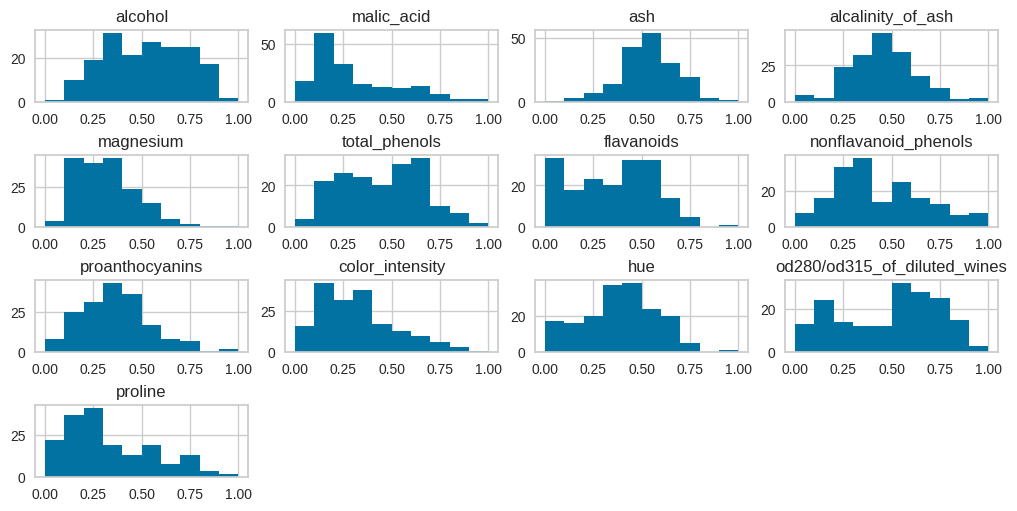

In [47]:
fig, axs = plt.subplots(figsize=(10, 5), layout='constrained')
wine_df[feature_columns].hist(ax=axs)

The ash is the only one that reseambles a normal, the others are skeewed or looks much more like a multi modal distribution. This will be the baseline for the model, let's make the predictions.

## 2.2 Base line for the wine dataset

In [48]:
#using the pycaret to test the models.
exp = ClassificationExperiment()
# init setup on exp
exp.setup(wine_df, target = 'target', preprocess = False)
# compare baseline models
best = exp.compare_models()

,Description,Value
0,Session id,3698
1,Target,target
2,Target type,Multiclass
3,Original data shape,"(178, 14)"
4,Transformed data shape,"(178, 14)"
5,Transformed train set shape,"(124, 14)"
6,Transformed test set shape,"(54, 14)"
7,Numeric features,13


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.9846,0.9964,0.9846,0.9877,0.9846,0.9770,0.9786,0.0040
lr,Logistic Regression,0.9840,0.9972,0.9840,0.9872,0.9840,0.9759,0.9776,0.2860
nb,Naive Bayes,0.9840,1.0000,0.9840,0.9869,0.9838,0.9756,0.9774,0.0040
rf,Random Forest Classifier,0.9840,0.9982,0.9840,0.9872,0.9840,0.9759,0.9776,0.0330
qda,Quadratic Discriminant Analysis,0.9833,1.0000,0.9833,0.9861,0.9824,0.9739,0.9759,0.0040
et,Extra Trees Classifier,0.9763,0.9995,0.9763,0.9814,0.9764,0.9643,0.9668,0.0270
ridge,Ridge Classifier,0.9679,0.0000,0.9679,0.9717,0.9681,0.9517,0.9535,0.0040
lightgbm,Light Gradient Boosting Machine,0.9679,1.0000,0.9679,0.9741,0.9667,0.9517,0.9556,45.8170
catboost,CatBoost Classifier,0.9679,0.9982,0.9679,0.9744,0.9679,0.9517,0.9552,1.8210
xgboost,Extreme Gradient Boosting,0.9673,0.9964,0.9673,0.9740,0.9671,0.9503,0.9539,0.0130


In [49]:
frame_wine_orig = exp.pull()

In [50]:
frame_wine_orig

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.9846,0.9964,0.9846,0.9877,0.9846,0.9770,0.9786,0.004
lr,Logistic Regression,0.9840,0.9972,0.9840,0.9872,0.9840,0.9759,0.9776,0.286
nb,Naive Bayes,0.9840,1.0000,0.9840,0.9869,0.9838,0.9756,0.9774,0.004
rf,Random Forest Classifier,0.9840,0.9982,0.9840,0.9872,0.9840,0.9759,0.9776,0.033
qda,Quadratic Discriminant Analysis,0.9833,1.0000,0.9833,0.9861,0.9824,0.9739,0.9759,0.004
et,Extra Trees Classifier,0.9763,0.9995,0.9763,0.9814,0.9764,0.9643,0.9668,0.027
ridge,Ridge Classifier,0.9679,0.0000,0.9679,0.9717,0.9681,0.9517,0.9535,0.004
lightgbm,Light Gradient Boosting Machine,0.9679,1.0000,0.9679,0.9741,0.9667,0.9517,0.9556,45.817
catboost,CatBoost Classifier,0.9679,0.9982,0.9679,0.9744,0.9679,0.9517,0.9552,1.821
xgboost,Extreme Gradient Boosting,0.9673,0.9964,0.9673,0.9740,0.9671,0.9503,0.9539,0.013


## 2.3 Normalizing and build the models.

Now we will build the model for the normalized features.

We will use the same transformer as before.

In [51]:
pt = QuantileTransformer(output_distribution='normal')

In [52]:
pt = pt.fit(wine_df[feature_columns])
#Let's save the old version.
wine_df_copy = wine_df.copy()
wine_df_copy[feature_columns] = pt.transform(wine_df_copy[feature_columns])

array([[<Axes: title={'center': 'alcohol'}>,
        <Axes: title={'center': 'malic_acid'}>,
        <Axes: title={'center': 'ash'}>,
        <Axes: title={'center': 'alcalinity_of_ash'}>],
       [<Axes: title={'center': 'magnesium'}>,
        <Axes: title={'center': 'total_phenols'}>,
        <Axes: title={'center': 'flavanoids'}>,
        <Axes: title={'center': 'nonflavanoid_phenols'}>],
       [<Axes: title={'center': 'proanthocyanins'}>,
        <Axes: title={'center': 'color_intensity'}>,
        <Axes: title={'center': 'hue'}>,
        <Axes: title={'center': 'od280/od315_of_diluted_wines'}>],
       [<Axes: title={'center': 'proline'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

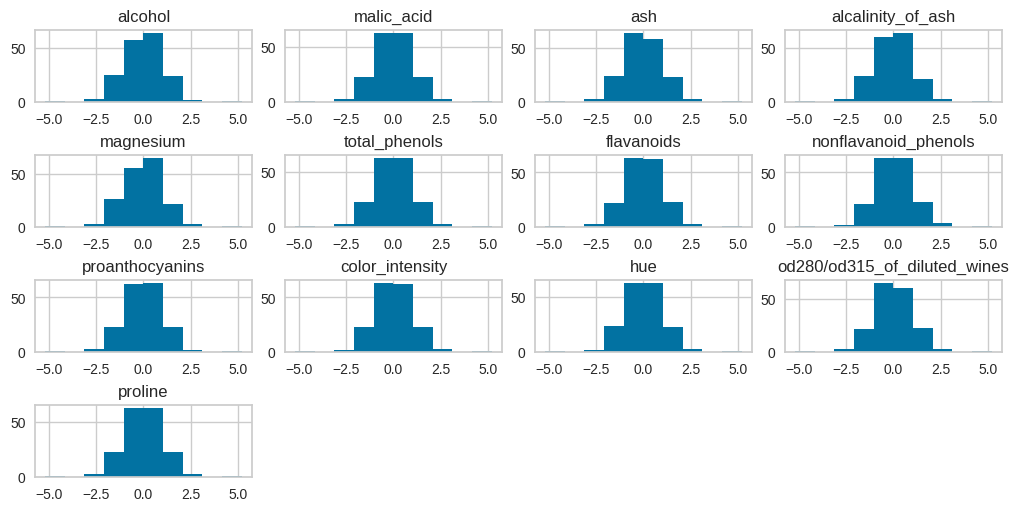

In [53]:
fig, axs = plt.subplots(figsize=(10, 5), layout='constrained')
wine_df_copy[feature_columns].hist(ax=axs)

Now that is much more normal like.
The next step is applying the models.

In [54]:
#using the pycaret to test the models.
exp = ClassificationExperiment()
# init setup on exp
exp.setup(wine_df_copy, target = 'target', preprocess = False)
# compare baseline models
best_norm = exp.compare_models()

,Description,Value
0,Session id,1121
1,Target,target
2,Target type,Multiclass
3,Original data shape,"(178, 14)"
4,Transformed data shape,"(178, 14)"
5,Transformed train set shape,"(124, 14)"
6,Transformed test set shape,"(54, 14)"
7,Numeric features,13


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9923,1.0000,0.9923,0.9942,0.9924,0.9884,0.9892,0.0100
lda,Linear Discriminant Analysis,0.9917,1.0000,0.9917,0.9933,0.9917,0.9874,0.9883,0.0040
et,Extra Trees Classifier,0.9917,1.0000,0.9917,0.9931,0.9912,0.9870,0.9880,0.0260
lr,Logistic Regression,0.9840,1.0000,0.9840,0.9873,0.9836,0.9753,0.9772,0.0050
rf,Random Forest Classifier,0.9840,1.0000,0.9840,0.9880,0.9842,0.9759,0.9776,0.0320
lightgbm,Light Gradient Boosting Machine,0.9840,1.0000,0.9840,0.9869,0.9838,0.9756,0.9774,44.8380
catboost,CatBoost Classifier,0.9840,1.0000,0.9840,0.9873,0.9839,0.9755,0.9773,1.9130
ridge,Ridge Classifier,0.9833,0.0000,0.9833,0.9871,0.9835,0.9749,0.9767,0.0040
svm,SVM - Linear Kernel,0.9756,0.0000,0.9756,0.9803,0.9751,0.9624,0.9652,0.0050
nb,Naive Bayes,0.9519,0.9886,0.9519,0.9613,0.9499,0.9259,0.9315,0.0040


In [55]:
frame_norm = exp.pull()

In [58]:
frame_norm

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9923,1.0000,0.9923,0.9942,0.9924,0.9884,0.9892,0.010
lda,Linear Discriminant Analysis,0.9917,1.0000,0.9917,0.9933,0.9917,0.9874,0.9883,0.004
et,Extra Trees Classifier,0.9917,1.0000,0.9917,0.9931,0.9912,0.9870,0.9880,0.026
lr,Logistic Regression,0.9840,1.0000,0.9840,0.9873,0.9836,0.9753,0.9772,0.005
rf,Random Forest Classifier,0.9840,1.0000,0.9840,0.9880,0.9842,0.9759,0.9776,0.032
lightgbm,Light Gradient Boosting Machine,0.9840,1.0000,0.9840,0.9869,0.9838,0.9756,0.9774,44.838
catboost,CatBoost Classifier,0.9840,1.0000,0.9840,0.9873,0.9839,0.9755,0.9773,1.913
ridge,Ridge Classifier,0.9833,0.0000,0.9833,0.9871,0.9835,0.9749,0.9767,0.004
svm,SVM - Linear Kernel,0.9756,0.0000,0.9756,0.9803,0.9751,0.9624,0.9652,0.005
nb,Naive Bayes,0.9519,0.9886,0.9519,0.9613,0.9499,0.9259,0.9315,0.004


## 2.4 - Comparing the results

Now we gonna compare the results.

In [56]:
results_list = []
results_index = []
#take the diference between the results
for index in frame_norm.index:
    results_norm = frame_norm.loc[index][1:]
    results_base = frame_wine_orig.loc[index][1:]
    results_index.append(index)
    results_list.append([results_norm - results_base])

dict_results = {index:[] for index in results_list[0][0].index}
#organizing on a dictionary
for key in dict_results.keys():
    for results in results_list:
        dict_results[key].append(results[0][key])
#transforming in a dictionary
results_wine_df = pd.DataFrame(dict_results)

In [57]:
#setting the index
results_wine_df['index'] = pd.DataFrame(results_index)
results_wine_df = results_wine_df.set_index('index')
results_wine_df

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
index,,,,,,,,
xgboost,0.0250,0.0036,0.0250,0.0202,0.0253,0.0381,0.0353,-0.003
lda,0.0071,0.0036,0.0071,0.0056,0.0071,0.0104,0.0097,0.000
et,0.0154,0.0005,0.0154,0.0117,0.0148,0.0227,0.0212,-0.001
lr,0.0000,0.0028,0.0000,0.0001,-0.0004,-0.0006,-0.0004,-0.281
rf,0.0000,0.0018,0.0000,0.0008,0.0002,0.0000,0.0000,-0.001
lightgbm,0.0161,0.0000,0.0161,0.0128,0.0171,0.0239,0.0218,-0.979
catboost,0.0161,0.0018,0.0161,0.0129,0.0160,0.0238,0.0221,0.092
ridge,0.0154,0.0000,0.0154,0.0154,0.0154,0.0232,0.0232,0.000
svm,0.0237,0.0000,0.0237,0.0203,0.0247,0.0362,0.0337,-0.001


From the results we can see just the logistic regression not perform worst then the baseline. As with the titanic dataset, now we gonna  take a look on the plots to see what happened.

In [57]:
import seaborn as sns

There is to much features to look, so we're going to select five columns.

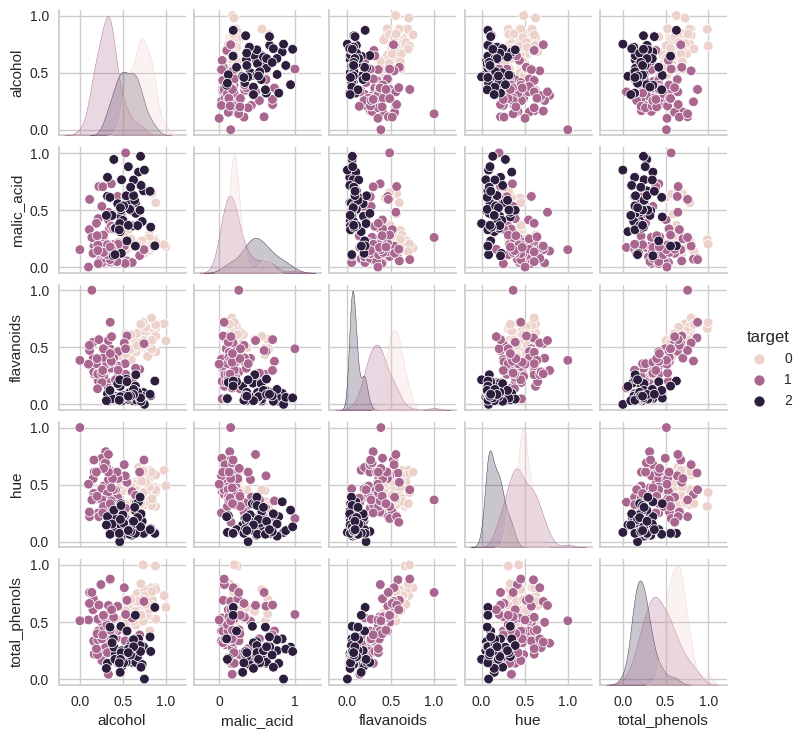

In [86]:
sns.pairplot(wine_df[['alcohol', 'malic_acid', 'flavanoids', 'hue',  'total_phenols','target']], hue="target", height=1.5)

We can see a concentration of a class which makes then separable. Let's see what happens when we apply normalization.

In [107]:
wine_df.columns

Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline', 'target'],
      dtype='object')

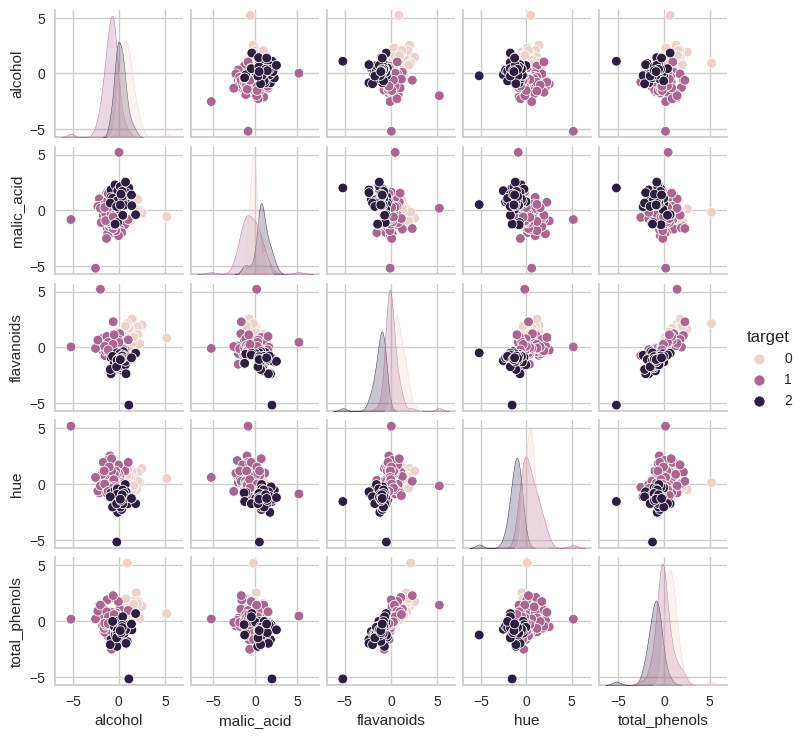

In [85]:
sns.pairplot(wine_df_copy[['alcohol', 'malic_acid', 'flavanoids', 'hue',  'total_phenols','target']], hue="target",height=1.5)

The normalization agglomerates all classes distribution to a single center. When we are trying to classify, the classes has to be separated and just normalizing the data makes all the classes aglomerated on a unique center. 

When the methods like logistic regression, linear discriminant analyses, quadratic discriminant analysis, naive bayes assumes a normalized distribution they mean with respect to the respective class, in other words each class is assumed to follows a exclusive normal distribution. What it means is each class has a point with high probability that the data whos is in proximity of this point is of that class, walking away from the central point of the distribution lower the chances in a normal probability fashion that the point belongs to the class. 

A good general line to follow when perform a classification is to make the class separable with the features. There's no absolute way to do this, just a bunch of transformations that you can use which can work. Each data set has a proper way to treat the features that makes the data more separable. This include feature engineer techniques like base transformations, scaling, and the encoder to use when transforming the categorical values, just use the same transformation for every dataset unfurtunely will not work.


## 3 - Conclusion 

This article objective is give some insights about the transformation of features for machine learning practioners in the beggining of the jorney with the data. The article try to clear the missconcept about normalization of the data that some begginers may have when reading about the classic models like linear discriminant analysis when they talk about the assumption of normaly distribution of the data.